## 📊 **Statistical Analysis of Graphic Profiles (GPs) - Section 7.2**

This notebook contains the code for Section 7.2 of the article, where we conduct a statistical analysis of our predetermined Graphic Profiles (GPs) to assess a complementary aspect of scribal *habitus*. ✍️

---

### 🧑‍💻 **For the analysis of the Graphic Profiles (GPs),**  
please refer to the notebook titled **"PCA.ipynb"**. This notebook dives deeper into the Principal Component Analysis (PCA) of the graphic profiles. 🔍

---

### 📑 **Interpretation of Results**  
For a detailed interpretation of the results, please refer to the **Discussion in Section 7.2** of the article, where we contextualize the statistical findings. The notebook follows the order of the results presented in the paper, with references to the relevant subsections, tables, and figures for easy cross-referencing

---

### 💾 **File Outputs**  
All generated tables and figures are saved in the `./results/statistical_analysis` folder. Feel free to explore these files for further analysis and presentation! 📂

## 🔧 **Imports**

In [2]:
import json
import os
import re
import csv
import unicodedata
import pandas as pd
import numpy as np
import statistics
from pathlib import Path


import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.font_manager import FontProperties
from IPython.display import display
from matplotlib.lines import Line2D

from PIL import Image
from collections import defaultdict

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

plt.rcParams['text.usetex'] = True

## 📁 **Base paths**

In [3]:
BASE_DIR = Path.cwd()

dataset_path = BASE_DIR / ".." / "dataset"
annotation_json_path = dataset_path / "annotation.json"
images_path = dataset_path / "images"
full_images_path = BASE_DIR / ".." / "data" / "images"

stats_dir = BASE_DIR / ".." / "results" / "statistical_analysis"
junicode_font_path = BASE_DIR / ".." / "Junicode.ttf"

##  🔍 To ensure the statistical analysis remains coherent, we first filter our dataset into two sub-datasets :

## ❌📝 We exclude 

### 1) the Latin folio in the first step to prevent Latin from skewing the abbreviation counts and other statistics.

### 2) incomplete or rubric lines in our line management statistics, as they would distort the overall results.


In [4]:
def filter_json_file(input_file, output_no_latin, output_full_lines):
    with open(input_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

    annotation_no_latin = {k: v for k, v in data.items() if not k.startswith("btv1b84472995_f987")}
    annotation_full_lines = {k: v for k, v in annotation_no_latin.items() if v.get("line") not in ["HalfLine", "RubricLine"]}

    for path, content in [(output_no_latin, annotation_no_latin), (output_full_lines, annotation_full_lines)]:
        with open(path, 'w', encoding='utf-8') as f:
            json.dump(content, f, ensure_ascii=False, indent=4)

    return annotation_no_latin, annotation_full_lines

# Example usage
annotation_no_latin_path = os.path.join(dataset_path, 'annotation_no_latin.json')
annotation_full_lines_path = os.path.join(dataset_path, 'annotation_full_lines.json')

annotation_no_latin, annotation_full_lines = filter_json_file(annotation_json_path, annotation_no_latin_path, annotation_full_lines_path)

## Now that we have our sub-datasets, we can start the statistical analysis. First, we’ll look at the macro statistics related to general abbreviation rates ✍️ (Section 7.2.1, Table 9).

In [5]:
def compute_macro_statistics(data):
    """
    Compute special character, word, and line frequencies for each script and return them in a DataFrame.
    """
    # Regex to match special characters
    special_char_regex = re.compile(r'[^a-zA-Z ΑΩ¶.*:]')

    # Dictionaries to store aggregated character frequencies, word data, and line counts for each script
    char_frequencies_by_script = {}
    word_data_by_script = {}
    line_counts_by_script = {}
    char_counts_per_line_by_script = {}

    # Initialize storage for the script if not already present
    for _, doc_data in data.items():
        script = doc_data.get('gp', 'Unknown')  # Script category
        label = doc_data.get('label', '')  # Text label

        # Normalize the label to NFC (Normalization Form C)
        normalized_label = unicodedata.normalize('NFD', label)
        normalized_label = normalized_label.replace('\'', '')
        normalized_label = normalized_label.replace('#', '').replace('j', 'i').replace('v', 'u')

        # Initialize storage for the script if not already present
        if script not in char_frequencies_by_script:
            char_frequencies_by_script[script] = []
            word_data_by_script[script] = {'total_words': 0, 'abbreviated_words': 0}
            line_counts_by_script[script] = 0
            char_counts_per_line_by_script[script] = 0

        # Increment the line count for this script
        line_counts_by_script[script] += 1

        # Split the text into words
        words = normalized_label.split()
        word_data_by_script[script]['total_words'] += len(words)

        # Check for abbreviated words
        for word in words:
            if any(special_char_regex.search(char) for char in word):
                word_data_by_script[script]['abbreviated_words'] += 1

        # Append the characters to the corresponding script
        char_frequencies_by_script[script].extend(list(normalized_label))

        # Count the number of characters (excluding spaces) for this line
        char_count_for_this_line = len([char for char in normalized_label if char != ' '])
        char_counts_per_line_by_script[script] += char_count_for_this_line

    # Prepare results to store in DataFrame
    results = []

    # Process the gathered data and compute statistics
    for script, characters in char_frequencies_by_script.items():
        # Remove spaces for special character frequency computation
        characters_no_space = [char for char in characters if char != ' ']

        # Count character occurrences
        char_counts_no_space = pd.Series(characters_no_space).value_counts()
        total_chars = char_counts_no_space.sum()

        # Apply regex to extract special characters
        special_chars = char_counts_no_space[char_counts_no_space.index.map(lambda x: bool(special_char_regex.match(str(x))))]
        special_char_count = special_chars.sum()
        special_char_percentage = round((special_char_count / total_chars) * 100, 1) if total_chars > 0 else 0

        # Word-level statistics
        total_words = word_data_by_script[script]['total_words']
        abbreviated_words = word_data_by_script[script]['abbreviated_words']
        abbreviated_word_percentage = round((abbreviated_words / total_words) * 100, 1) if total_words > 0 else 0

        # Line count for the script
        total_lines = line_counts_by_script[script]

        # Store the results
        results.append({
            "Graphic Profile": script,
            "Total Lines": total_lines,
            "Total Characters": total_chars,
            "Special Characters Count": special_char_count,
            "Special Characters Percentage": special_char_percentage,
            "Graphic Units: Total": total_words,
            "Abbreviated Graphic Units": abbreviated_words,
            "Abbreviated Graphic Units: Percentage": abbreviated_word_percentage,
        })

    # Convert the results list into a DataFrame
    results_df = pd.DataFrame(results)

    # Sort the DataFrame by 'Graphic Profile' to ensure GP1, GP2, GP3, GP4 are in order
    results_df['Graphic Profile'] = pd.Categorical(results_df['Graphic Profile'], categories=['GP1', 'GP2', 'GP3', 'GP4'], ordered=True)
    results_df = results_df.sort_values('Graphic Profile')

    return results_df

# Example usage with your filtered dataset (assuming 'filtered_no_latin' is already available)
results_df = compute_macro_statistics(annotation_no_latin)

# Display the results DataFrame
display(results_df)

# Define the relative path to save the CSV file in the stats_dir
csv_file_path = os.path.join(stats_dir, "macro_statistic_results.csv")

# Save the results DataFrame to the CSV file
results_df.to_csv(csv_file_path, index=False)

print(f"Results saved to {csv_file_path}")

,Graphic Profile,Total Lines,Total Characters,Special Characters Count,Special Characters Percentage,Graphic Units: Total,Abbreviated Graphic Units,Abbreviated Graphic Units: Percentage
2,GP1,2400,83395,3591,4.3,20352,3429,16.8
1,GP2,2009,62680,866,1.4,14542,848,5.8
0,GP3,1590,54444,551,1.0,12709,535,4.2
3,GP4,464,15940,204,1.3,3652,197,5.4


Results saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/statistical_analysis/macro_statistic_results.csv


## Next up, building on the general abbreviation rates, we calculate the frequency of specific abbreviative marks per GP ✍️ (Section 7.2.1, Table 10, Figure 18).

In [6]:
# General visualisation parameters
# Load the Junicode font using the relative path
junicode_font = FontProperties(fname=junicode_font_path)

# Set the Seaborn palette and legend labels
legend_labels = ["GP1", "GP2", "GP3", "GP4"]

gp_colors = {
    "GP1": "#009E73", 
    "GP2": "#E69F00", 
    "GP3": "#0072B2",  
    "GP4": "#CC79A7", 
}

gp_markers = {
    "GP1": 'o',
    "GP2": 'x',
    "GP3": '^',
    "GP4": 'D',
}

legend_colors = [gp_colors[label] for label in legend_labels]

/var/folders/ps/09_p7rl14y11qx52mcmvrr_w0000gq/T/ipykernel_21615/3178008436.py:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: f'{x[0]} ({x[1]:.2f}%)' if isinstance(x, tuple) else x)


,GP1 Count (%),GP2 Count (%),GP3 Count (%),GP4 Count (%)
̃,1617 (45.03%),406 (46.88%),257 (46.64%),113 (55.39%)
⁊,564 (15.71%),183 (21.13%),67 (12.16%),2 (0.98%)
ẜ,58 (1.62%),90 (10.39%),53 (9.62%),19 (9.31%)
ꝑ,292 (8.13%),13 (1.50%),25 (4.54%),11 (5.39%)
̾,354 (9.86%),21 (2.42%),12 (2.18%),10 (4.90%)
ł,130 (3.62%),20 (2.31%),24 (4.36%),8 (3.92%)
ͣ,145 (4.04%),15 (1.73%),17 (3.09%),4 (1.96%)
ͤ,6 (0.17%),25 (2.89%),22 (3.99%),6 (2.94%)
᷑,61 (1.70%),16 (1.85%),9 (1.63%),8 (3.92%)
ꝯ,178 (4.96%),6 (0.69%),10 (1.81%),2 (0.98%)


/var/folders/ps/09_p7rl14y11qx52mcmvrr_w0000gq/T/ipykernel_21615/3178008436.py:58: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_numeric = df.applymap(lambda x: float(x.split('(')[1][:-2]) if isinstance(x, str) and '(' in x else 0)


<Figure size 1400x800 with 0 Axes>

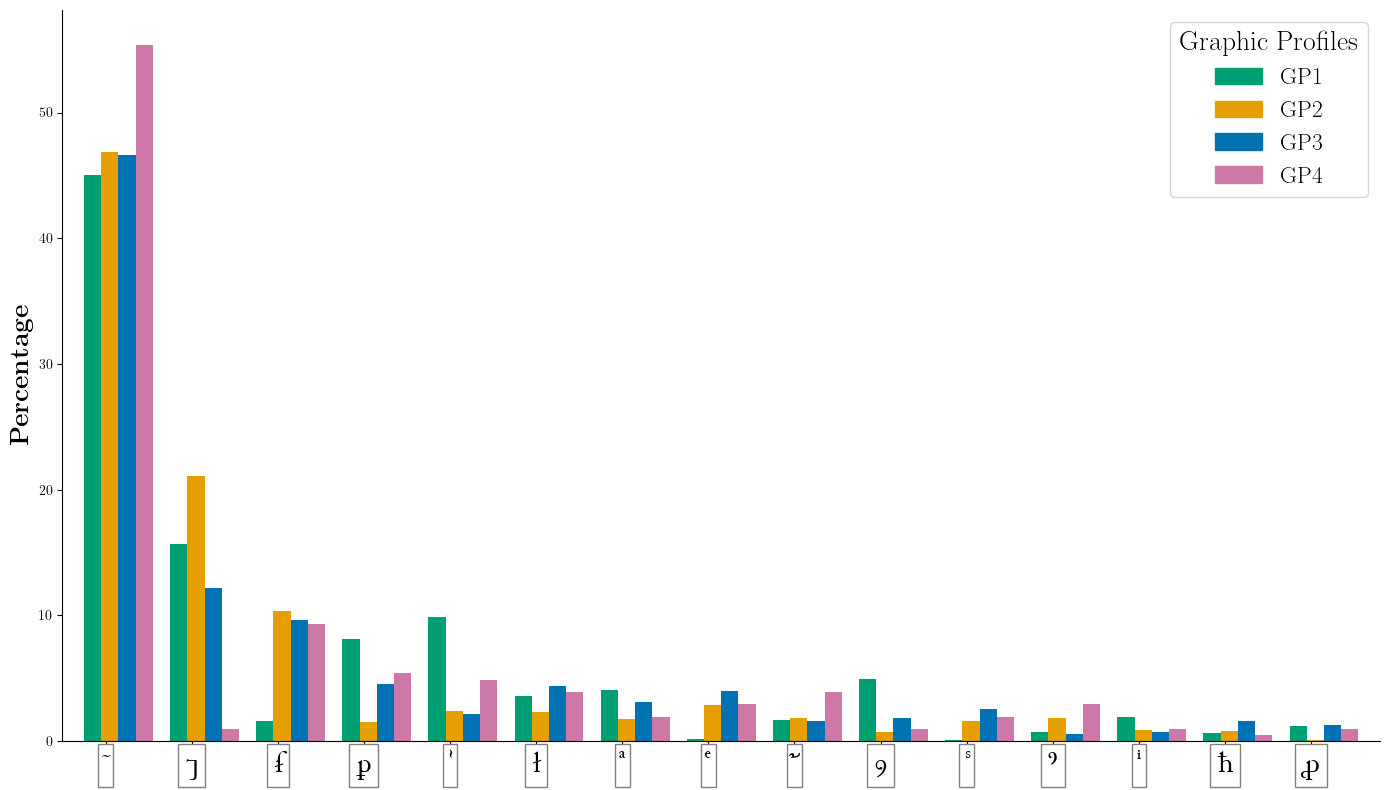

In [7]:
def compute_abbreviative_mark_frequencies(data):
    special_char_regex = re.compile(r'[^a-zA-Z ΑΩ¶.*:]') #comment this
    char_frequencies_by_gp = {}
    total_special_chars_by_gp = {}
    
    for _, doc_data in data.items():
        gp = doc_data.get('gp', 'Unknown')
        label = doc_data.get('label', '')
        normalized_label = unicodedata.normalize('NFD', label).replace("'", "").replace("#", "").replace("j", "i").replace("v", "u")
        
        if gp not in char_frequencies_by_gp:
            char_frequencies_by_gp[gp] = []
            total_special_chars_by_gp[gp] = 0
        
        chars = [char for char in normalized_label if char != ' ']
        char_frequencies_by_gp[gp].extend(chars)
    
    df_data = {}
    all_chars = set()
    
    for gp, chars in char_frequencies_by_gp.items():
        char_counts = pd.Series(chars).value_counts()
        special_chars = char_counts[char_counts.index.map(lambda x: bool(special_char_regex.match(str(x))))]
        total_special_chars_by_gp[gp] = special_chars.sum()
        
        df_data[gp] = {char: (count, (count / total_special_chars_by_gp[gp]) * 100 if total_special_chars_by_gp[gp] > 0 else 0) 
                       for char, count in special_chars.items()}
        all_chars.update(special_chars.index)
    
    # Compute the average percentage across all GPs for sorting
    char_avg_percentage = {
        char: np.mean([
            df_data.get(gp, {}).get(char, (0, 0))[1]  # Get the percentage for each GP
            for gp in df_data.keys()
        ])
        for char in all_chars
    }

    # Sort characters by their average percentage across all groups
    all_chars = sorted(char_avg_percentage.keys(), key=lambda char: char_avg_percentage[char], reverse=True)

    df = pd.DataFrame(index=all_chars)
    
    for gp in sorted(df_data.keys()):
        df[f'{gp} Count (%)'] = df.index.map(lambda char: df_data[gp].get(char, (0, 0)))
    
    df = df.applymap(lambda x: f'{x[0]} ({x[1]:.2f}%)' if isinstance(x, tuple) else x)
    
    df['Avg %'] = df.index.map(lambda char: char_avg_percentage.get(char, 0))
    top_15_chars = df.nlargest(15, 'Avg %')
    top_15_chars = top_15_chars.drop(columns=['Avg %'])
    
    return top_15_chars

def plot_histogram(df, log_scale=False):
    plt.figure(figsize=(14, 8))
    
    df_numeric = df.applymap(lambda x: float(x.split('(')[1][:-2]) if isinstance(x, str) and '(' in x else 0)
    
    if log_scale:
        df_numeric = df_numeric.applymap(lambda x: np.log(x + 1) if x > 0 else 0)
    
    ax = df_numeric.plot(kind='bar', width=0.8, color=legend_colors, figsize=(14, 8), position=0)
    
    if log_scale:
        ax.set_yscale("log")
    
    ax.set_ylabel(r'$\textbf{Percentage}$', fontsize=19)
    
    for label in ax.get_xticklabels():
        label.set_fontproperties(junicode_font)
        label.set_fontsize(20)
        label.set_usetex(False)
        xticks_pos = np.arange(len(df_numeric.index))
        ax.set_xticks(xticks_pos + 0.2)
        plt.xticks(
            xticks_pos + 0.25, 
            df_numeric.index, 
            rotation=0, 
            fontproperties=junicode_font, 
            fontsize=21, 
            fontweight='bold'
        )

        for label in ax.get_xticklabels():
            label.set_bbox(dict(facecolor='white', edgecolor='grey', boxstyle='square,pad=0.25'))

    legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
    ax.legend(title="Graphic Profiles", handles=legend_patches, loc='upper right', title_fontsize=20, fontsize=17)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    # Save the figure as a PNG file
    histogram_path = os.path.join(stats_dir, "abbreviative_mark_frequency_per_GP.png")
    plt.savefig(histogram_path)
    
    plt.show()
    return df_numeric

if __name__ == "__main__":
    # Compute frequencies and save to DataFrame
    df = compute_abbreviative_mark_frequencies(annotation_no_latin)
    display(df)

    # Save results as a CSV file in the relative `stats_dir`
    csv_file_path = os.path.join(stats_dir, "abbreviative_mark_frequency_per_GP.csv")
    df.to_csv(csv_file_path, index=True)

    # Plot histogram
    histogram_df = plot_histogram(df, log_scale=False)

## Next, we dive deeper by calculating the specific syllabic abbreviation usage/frequency per GP ✍️(Section 7.2.1, Table 11, Figure 19).

In [20]:
def compute_syllabic_sequence_abbreviation_frequency(data, reverse_abbreviation_map):
    """
    Compute abbreviation percentages and detailed counts per script.
    """
    # Initialize abbreviation data for each script
    script_abbreviation_data = {gp: {abbr: {"abbr": 0, "unabbr": 0} for abbr in reverse_abbreviation_map} for gp in legend_labels}
    scribe_labels = {}

    # Process each document
    for _, doc_data in data.items():
        label = doc_data.get('label', '').lower()  # Normalize to lowercase
        script = doc_data.get('gp', 'Unknown')

        # Concatenate labels for each script
        if script not in scribe_labels:
            scribe_labels[script] = ""
        scribe_labels[script] += label

    # Count frequencies from normalized labels
    for script, combined_label in scribe_labels.items():
        normalized_label = unicodedata.normalize('NFD', combined_label)

        for abbr, full_list in reverse_abbreviation_map.items():
            abbr_pattern = unicodedata.normalize('NFD', abbr)
            abbr_count = len(re.findall(re.escape(abbr_pattern), normalized_label, flags=re.UNICODE))

            full_count = 0
            for full in full_list:
                full_pattern = unicodedata.normalize('NFD', full)
                full_count += len(re.findall(re.escape(full_pattern), normalized_label, flags=re.UNICODE))

            script_abbreviation_data[script][abbr]["abbr"] += abbr_count
            script_abbreviation_data[script][abbr]["unabbr"] += full_count

    # Build the final DataFrame
    abbreviation_data = []
    for abbr, full_list in reverse_abbreviation_map.items():
        row = {
            "Abbreviated Sequence": abbr,
            "Unabbreviated Sequences": ", ".join(full_list)
        }

        for script in legend_labels:
            counts = script_abbreviation_data.get(script, {}).get(abbr, {"abbr": 0, "unabbr": 0})
            abbr_count = counts["abbr"]
            unabbr_count = counts["unabbr"]
            total = abbr_count + unabbr_count
            abbr_percentage = (abbr_count / total * 100) if total > 0 else 0

            row[f"{script} Unabbr."] = unabbr_count
            row[f"{script} Abbr."] = abbr_count
            row[f"{script} Total"] = total
            row[f"{script} % of abbr."] = round(abbr_percentage, 1)

        abbreviation_data.append(row)

    df = pd.DataFrame(abbreviation_data)

    # Add Average % column
    percentage_columns = [f"{script} % of abbr." for script in legend_labels]
    df["Average %"] = df[percentage_columns].mean(axis=1)

    # Sort by Average %
    df = df.sort_values(by="Average %", ascending=False)

    # Save to CSV
    csv_path = os.path.join(stats_dir, "syllabic_sequence_abbreviation_per_GP.csv")
    df.to_csv(csv_path, index=False)

    # Display
    display(df)

    return df

def plot_abbreviation_histogram(df, abbreviation_subset=None):
    """
    Plot a grouped bar histogram for abbreviation percentage per script.
    Filters the DataFrame if a subset of abbreviations is provided.
    """
    if abbreviation_subset is not None:
        df = df[df["Abbreviated Sequence"].isin(abbreviation_subset)]

    # Set index and continue as before
    df = df.set_index("Abbreviated Sequence")
    
    fig, ax = plt.subplots(figsize=(14, 8))
    df_numeric = df[[f"{script} % of abbr." for script in legend_labels]]
    df_numeric.plot(kind='bar', width=0.8, color=legend_colors, ax=ax)
    
    ax.set_ylabel(r'\textbf{Abbreviation Usage (\%)}', fontsize=19)
    ax.set_xticklabels(df.index, rotation=0)
    ax.set_xlabel(None, labelpad=0)

    for label in ax.get_xticklabels():
        label.set_fontproperties(junicode_font)
        label.set_fontsize(21)
        label.set_fontweight('bold')
        label.set_usetex(False)
        label.set_bbox(dict(facecolor='white', edgecolor='grey', boxstyle='square,pad=0.25'))

    legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
    ax.legend(title="Graphic Profiles", handles=legend_patches, loc='upper right', title_fontsize=20, fontsize=17)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    
    histogram_path = os.path.join(stats_dir, "syllabic_sequence_abbreviation_per_GP.png")
    plt.savefig(histogram_path)

    plt.show()

In [17]:
if __name__ == "__main__":
    data = annotation_full_lines  

    abbreviation_map = {
        "⁊": [" et "], "ꝯ": ["com", "con"], "ꝰ": ["us "], "ꝑ": ["par", "per"], "ꝓ": ["pro"],
        "e᷑": ["eur"], "o᷑": ["our"], "ẜ": ["ser"], "qͥ": ["qui"], 
        "ã": ["am", "an"], "ẽ": ["en", "em"], "õ": ["om", "on"], "ĩ": ["in", "im"],
        "q̃": ["que"], "m̃t": ["ment"], "p̾": ["pre"],
        "g̾": ["ger", "gier", "gre"], "b̾": ["ber", "bier", "bre"],
        "c̾": ["cer", "cier", "cre", "cetera"], "t̾": ["tre", "ter"],
        "u̾": ["uer"], "n̾": ["ner", "nier"], "m̾": [" mer"],
        "młt": ["moult"], "chłr": ["cheualier"], "bñ": ["bien"],
    }

    df = compute_syllabic_sequence_abbreviation_frequency(data, abbreviation_map)

,Abbreviated Sequence,Unabbreviated Sequences,GP1 Unabbr.,GP1 Abbr.,GP1 Total,GP1 % of abbr.,GP2 Unabbr.,GP2 Abbr.,GP2 Total,GP2 % of abbr.,GP3 Unabbr.,GP3 Abbr.,GP3 Total,GP3 % of abbr.,GP4 Unabbr.,GP4 Abbr.,GP4 Total,GP4 % of abbr.,Average %
23,młt,moult,0,66,66,100.0,6,8,14,57.1,10,11,21,52.4,0,2,2,100.0,77.375
7,ẜ,ser,47,58,105,55.2,57,87,144,60.4,25,50,75,66.7,10,18,28,64.3,61.650
24,chłr,cheualier,2,37,39,94.9,18,3,21,14.3,12,3,15,20.0,0,3,3,100.0,57.300
4,ꝓ,pro,29,41,70,58.6,38,1,39,2.6,14,7,21,33.3,4,2,6,33.3,31.950
11,õ,"om, on",790,434,1224,35.5,804,192,996,19.3,580,110,690,15.9,204,55,259,21.2,22.975
14,m̃t,ment,50,167,217,77.0,124,3,127,2.4,102,7,109,6.4,42,1,43,2.3,22.025
0,⁊,et,538,562,1100,51.1,594,181,775,23.4,609,65,674,9.6,194,2,196,1.0,21.275
3,ꝑ,"par, per",207,288,495,58.2,335,12,347,3.5,323,24,347,6.9,78,10,88,11.4,20.000
25,bñ,bien,13,29,42,69.0,18,1,19,5.3,39,1,40,2.5,5,0,5,0.0,19.200
13,q̃,que,287,242,529,45.7,374,20,394,5.1,363,27,390,6.9,117,11,128,8.6,16.575


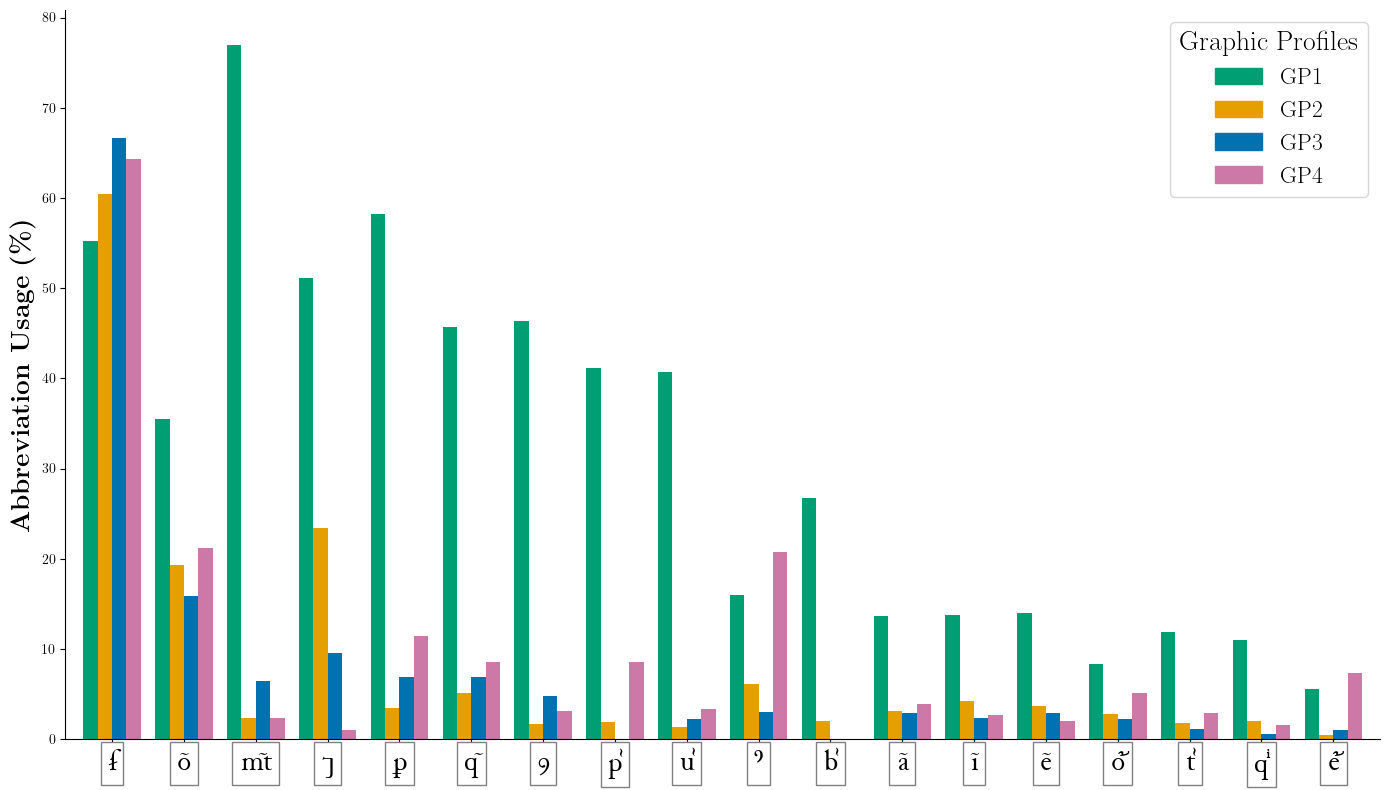

In [21]:
abbreviation_map_histogram = {
    "⁊": [" et "], "ꝯ": ["com", "con"], "ꝰ": ["us "], "ꝑ": ["par", "per"],
    "e᷑": ["eur"], "o᷑": ["our"], "ẜ": ["ser"], "qͥ": ["qui"], 
    "ã": ["am", "an"], "ẽ": ["en", "em"], "õ": ["om", "on"], "ĩ": ["in", "im"],
    "q̃": ["que"], "m̃t": ["ment"], "p̾": ["pre"],
    "b̾": ["ber", "bier", "bre"], 
    "t̾": ["tre", "ter"],
    "u̾": ["uer"]
}


    # Only plot abbreviations in abbreviation_map_histogram
plot_abbreviation_histogram(df, abbreviation_subset=abbreviation_map_histogram.keys())

## Next, we move to Section 7.2.2: Line Management Strategies. First, we calculate the relative position of abbreviations in the line  ✍️ (Figure 20).

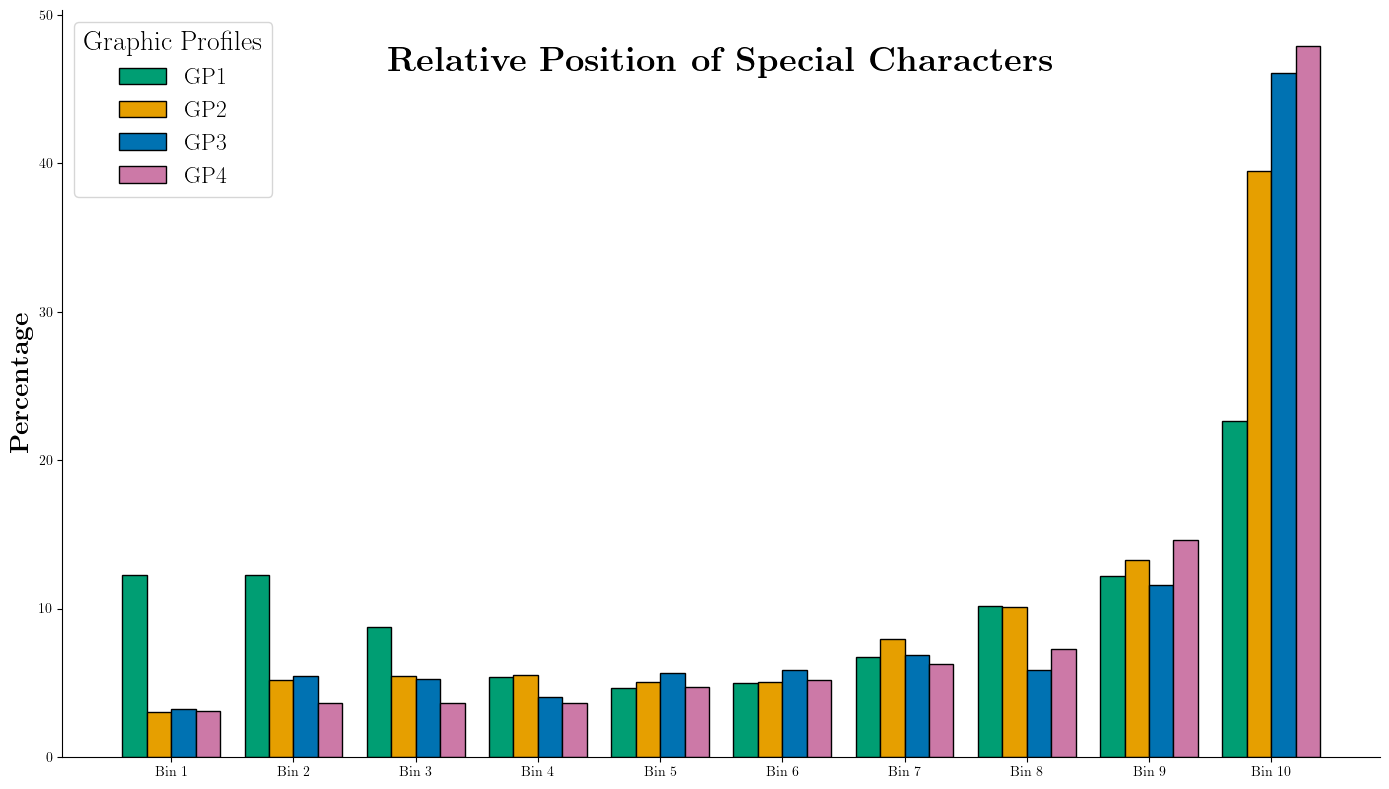

In [9]:
def compute_relative_position_histogram(data, font_path, output_path, count_threshold=None):
    """
    Compute and plot an aggregated histogram for the relative positions of all special characters per script.
    Save both DataFrame and plot without displaying them.
    """

    aggregated_relative_positions = {}
    non_alpha_regex = re.compile(r'[^a-zA-Z ΑΩ̶¶.*:]')

    for _, doc_data in data.items():
        script = doc_data.get('gp', 'Unknown')
        label = doc_data.get('label', '')

        normalized_label = unicodedata.normalize('NFD', label).replace('#', '').replace('j', 'i').replace('v', 'u')
        non_alpha_positions = [(i, char) for i, char in enumerate(normalized_label) if non_alpha_regex.match(char)]

        if not non_alpha_positions:
            continue

        total_length = len(normalized_label)
        num_bins = 10
        bin_size = total_length * 0.10
        bin_ranges = [(int(i * bin_size), int((i + 1) * bin_size)) for i in range(num_bins)]
        bin_ranges[-1] = (bin_ranges[-1][0], total_length)

        if script not in aggregated_relative_positions:
            aggregated_relative_positions[script] = {f"Bin {i + 1}": 0 for i in range(num_bins)}

        for pos, _ in non_alpha_positions:
            for bin_idx, (start, end) in enumerate(bin_ranges):
                if start <= pos < end:
                    bin_name = f"Bin {bin_idx + 1}"
                    aggregated_relative_positions[script][bin_name] += 1
                    break

    df = pd.DataFrame(aggregated_relative_positions).transpose()
    bins = [f"Bin {i+1}" for i in range(num_bins)]
    df = df.div(df.sum(axis=1), axis=0) * 100

    # Save DataFrame
    csv_path = os.path.join(output_path, "relative_position_special_characters_per_GP.csv")
    df.to_csv(csv_path)

    # Sort scripts following legend_labels order
    script_order = legend_labels

    fig, ax = plt.subplots(figsize=(14, 8))
    x = np.arange(len(bins))
    num_scripts = len(script_order)
    bar_width = 0.8 / num_scripts

    for idx, script in enumerate(script_order):
        ax.bar(
            x + (idx - (num_scripts - 1) / 2) * bar_width,
            df.loc[script],
            width=bar_width,
            label=script,
            edgecolor='black',
            color=gp_colors[script],
            align="center"
        )

    # Title inside the graph
    ax.text(
        0.5, 0.95,
        r'$\textbf{Relative\ Position\ of\ Special\ Characters}$',
        fontsize=25, 
        ha='center', va='top',
        transform=ax.transAxes
    )

    ax.set_ylabel(r'$\textbf{Percentage}$', fontsize=19)
    ax.set_xticks(x)
    ax.set_xticklabels(bins, fontsize=19, fontproperties=junicode_font)
    ax.legend(title="Graphic Profiles", title_fontsize=20, fontsize=17)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()

    # Save figure
    fig_path = os.path.join(output_path, "relative_position_special_characters_per_GP.png")
    plt.savefig(fig_path)
    
    plt.show()

    plt.close(fig)

# Example usage
if __name__ == "__main__":
    data = annotation_full_lines
    compute_relative_position_histogram(data, junicode_font_path, stats_dir, count_threshold=0)

## Finally, we calculate the average line length (in mm), the standard deviation of this practice as a proxy for stability/instability, and the average number of characters per line ✍️ (Section 7.2.2, Table 12, Figure 21).

In [10]:
def natural_sort_key(text):
    """
    Generate a sort key for natural sorting, where numeric parts of strings are treated as numbers.
    """
    return [int(part) if part.isdigit() else part for part in re.split(r'(\d+)', text)]

def create_metadata_mapping(annotation_json_path):
    """
    Create mappings from folder names to folio numbers and graphic profiles.
    """
    with open(annotation_json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    folio_mapping = {}
    graphic_profile_mapping = {}

    for filename_with_ext, metadata in data.items():
        filename = filename_with_ext.replace(".png", "")

        # Special case: replace '_f960' with '_f96'
        #if filename.endswith('_f960'):
        #    filename = filename.replace('_f960', '_f96')

        parts = filename.split('_')
        if len(parts) < 2:
            continue  # skip malformed names

        folder_name = '_'.join(parts[:2])

        folio_mapping[folder_name] = metadata.get('folio')
        graphic_profile_mapping[folder_name] = metadata.get('gp', 'Unknown')

    return folio_mapping, graphic_profile_mapping

def calculate_line_statistics(images_dir, base_images_dir, json_path, output_path, dpi):
    """
    Calculate the average length of PNG images in each subfolder and by graphic profile, in millimeters.
    """
    pixel_to_mm = 25.4 / dpi  # Conversion factor from pixels to millimeters

    # Load JSON metadata
    with open(annotation_full_lines_path, 'r') as f:
        json_metadata = json.load(f)

    # Build folio and graphic profile mappings
    folio_mapping, graphic_profile_mapping = create_metadata_mapping(annotation_json_path)

    avg_lengths_per_subfolder = {}
    
    # Modified data structures to store raw data for each graphic profile
    graphic_profile_lengths = {}  # To store all lengths for each graphic profile
    graphic_profile_std_dev = {}  # To store standard deviation for each graphic profile
    graphic_profile_total_chars = {}  # To store total characters for each GP
    graphic_profile_total_lines = {}  # To store total line count for each GP

    subfolders = sorted(
        [folder for folder in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, folder))],
        key=natural_sort_key
    )

    for subfolder in subfolders:
        lengths = []
        total_characters = 0
        total_lines = 0

        folio = folio_mapping.get(subfolder, 'Unknown')
        graphic_profile = graphic_profile_mapping.get(subfolder, 'Unknown')

        # Base image path
        base_subfolder = re.sub(r'([a-z])$', '', subfolder)
        base_image_path = os.path.join(base_images_dir, f"{base_subfolder}.jpg")

        if not os.path.isfile(base_image_path):
            print(f"Base image not found for subfolder '{subfolder}': {base_image_path}")
            continue

        try:
            with Image.open(base_image_path) as base_img:
                base_width, base_height = base_img.size
        except Exception as e:
            print(f"Error processing base image {base_image_path}: {e}")
            continue

        for filename_with_ext, metadata in json_metadata.items():
            # Remove ".png" to match naming
            filename = filename_with_ext.replace(".png", "")

            # Extract the subfolder from the filename
            parts = filename.split('_')
            if len(parts) < 2:
                continue
            folder_from_filename = '_'.join(parts[:2])

            if folder_from_filename != subfolder:
                continue  # Skip if not belonging to the current subfolder

            label = metadata.get('label', '')

            if not label:
                print(f"Skipping file {filename_with_ext} due to missing label.")
                continue

            line_length = len(label)
            total_characters += line_length
            total_lines += 1

            # Try to open image to get width
            file_path = os.path.join(images_dir, subfolder, filename_with_ext)
            if not os.path.isfile(file_path):
                print(f"Image file {file_path} not found for corresponding JSON entry.")
                continue

            try:
                with Image.open(file_path) as img:
                    width, height = img.size
                    length_mm = (width / base_width) * (base_width * pixel_to_mm)
                    lengths.append(length_mm)
            except Exception as e:
                print(f"Error processing image {file_path}: {e}")

        # Rest stays the same...
        avg_length_mm = sum(lengths) / len(lengths) if lengths else 0
        avg_char_per_line = total_characters / total_lines if total_lines else 0
        standard_deviation = statistics.stdev(lengths) if len(lengths) > 1 else 0

        avg_lengths_per_subfolder[subfolder] = {
            "Folio": folio,
            "Graphic Profile": graphic_profile,
            "Average Line Length (mm)": avg_length_mm,
            "Average Characters per Line": avg_char_per_line,
            "Standard Deviation (mm)": standard_deviation,
            "Total Lines": total_lines,  # Correct line count from JSON!
        }

        # Initialize data structures for this graphic profile if needed
        if graphic_profile not in graphic_profile_lengths:
            graphic_profile_lengths[graphic_profile] = []
            graphic_profile_std_dev[graphic_profile] = []
            graphic_profile_total_chars[graphic_profile] = 0
            graphic_profile_total_lines[graphic_profile] = 0
        
        # Accumulate raw data for each graphic profile
        graphic_profile_lengths[graphic_profile].extend(lengths)
        graphic_profile_std_dev[graphic_profile].append(standard_deviation)
        graphic_profile_total_chars[graphic_profile] += total_characters
        graphic_profile_total_lines[graphic_profile] += total_lines

    # Compute average statistics for each graphic profile
    avg_stats_per_gp = []
    for gp in graphic_profile_lengths:
        lengths = graphic_profile_lengths[gp]
        total_chars = graphic_profile_total_chars[gp]
        total_lines = graphic_profile_total_lines[gp]
        
        # Calculate average length directly from all collected lengths
        avg_length = round(sum(lengths) / len(lengths), 1) if lengths else 0
        
        # Calculate average characters per line from total characters and total lines
        avg_char = round(total_chars / total_lines, 1) if total_lines > 0 else 0
        
        # Average of standard deviations (this is still an average of averages, but that's expected for std dev)
        avg_std_dev = round(sum(graphic_profile_std_dev.get(gp, [])) / len(graphic_profile_std_dev.get(gp, [])), 1)
        #avg_std_dev = round(statistics.stdev(lengths), 1) if len(lengths) > 1 else 0 # this version calculates a global std, but it's essential to first average per page
        
        avg_stats_per_gp.append({
            "Graphic Profile": gp,
            "Average Line Length (mm)": avg_length,
            "Average Characters per Line": avg_char,
            "Average Standard Deviation (mm)": avg_std_dev,
            "Total Characters": total_chars,
            "Total Lines": total_lines
        })

    # Create DataFrame for graphic profile statistics
    df_gp_stats = pd.DataFrame(avg_stats_per_gp)

    # Create DataFrame for subfolder statistics
    df_avg_lengths_per_subfolder = pd.DataFrame.from_dict(avg_lengths_per_subfolder, orient='index')

    # Save to CSV
    subfolder_csv_path = os.path.join(output_path, "average_lengths_per_folio.csv")
    df_avg_lengths_per_subfolder.to_csv(subfolder_csv_path, index_label="Subfolder")

    display(df_gp_stats)

    # Save the graphic profile statistics to CSV
    gp_stats_csv_path = os.path.join(output_path, "average_line_statistics_per_GP.csv")
    df_gp_stats.to_csv(gp_stats_csv_path, index=False)
    print(f"Saved 'Average Statistics per Graphic Profile' to '{gp_stats_csv_path}'")

    # Return results
    return df_avg_lengths_per_subfolder, df_gp_stats

## Plot the scatterplot

In [11]:
def create_scatter_plot(subfolder_df, gp_mapping, folio_mapping, output_path):
    fig, ax = plt.subplots(figsize=(12, 8))

    gps_in_data = set()
    plotted_count = 0
    skipped_count = 0
    skipped_few_lines_count = 0

    for subfolder, row in subfolder_df.iterrows():
        gp = gp_mapping.get(subfolder)
        if gp is None or gp == "Unknown":
            skipped_count += 1
            continue

        # Check if "Total Lines" is available
        total_lines = row.get("Total Lines", None)
        if total_lines is not None and total_lines < 15:
            skipped_few_lines_count += 1
            continue

        folio = folio_mapping.get(subfolder, "Unknown")
        gps_in_data.add(gp)
        plotted_count += 1

        color = gp_colors.get(gp, 'gray')
        marker = gp_markers.get(gp, 'o')

        ax.scatter(
            row["Average Line Length (mm)"],
            row["Average Characters per Line"],
            color=color,
            marker=marker,
            s=90,
            alpha=0.9,
            edgecolors='black'
        )

        ax.annotate(
            folio,
            (row["Average Line Length (mm)"], row["Average Characters per Line"]),
            fontsize=12,
            alpha=0.8,
            xytext=(5, 5),
            textcoords='offset points',
        )

    print(f"Plotted {plotted_count} subfolders.")
    print(f"Skipped {skipped_count} subfolders without GP mapping.")
    print(f"Skipped {skipped_few_lines_count} subfolders with less than 15 lines.")

    ax.set_xlabel(r'$\textbf{Average Line Length (mm)}$', fontsize=18)
    ax.set_ylabel(r'$\textbf{Average Characters Per Line}$', fontsize=18)

    # Build custom legend
    legend_elements = [
        Line2D([0], [0], marker=gp_markers[gp], color='w',
               markerfacecolor=gp_colors[gp], markeredgecolor='black',
               markersize=12, label=gp)
        for gp in sorted(gps_in_data) if gp in gp_colors
    ]
    ax.legend(title="Graphic Profiles", handles=legend_elements, loc='upper left', title_fontsize=16, fontsize=14)

    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    plt.grid(True, alpha=0.4)

    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    print(f"Scatter plot saved to {output_path}")
    plt.show()

,Graphic Profile,Average Line Length (mm),Average Characters per Line,Average Standard Deviation (mm),Total Characters,Total Lines
0,GP1,63.7,42.3,1.3,100411,2373
1,GP2,64.9,38.2,3.1,70590,1849
2,GP3,66.2,41.9,3.0,60491,1442
3,GP4,64.5,41.7,2.8,18118,435


Saved 'Average Statistics per Graphic Profile' to '/Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/statistical_analysis/average_line_statistics_per_GP.csv'
Plotted 68 subfolders.
Skipped 0 subfolders without GP mapping.
Skipped 2 subfolders with less than 15 lines.


/var/folders/ps/09_p7rl14y11qx52mcmvrr_w0000gq/T/ipykernel_21615/186741799.py:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


Scatter plot saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/statistical_analysis/avg_line_length_characters_per_GP_scatterplot.png


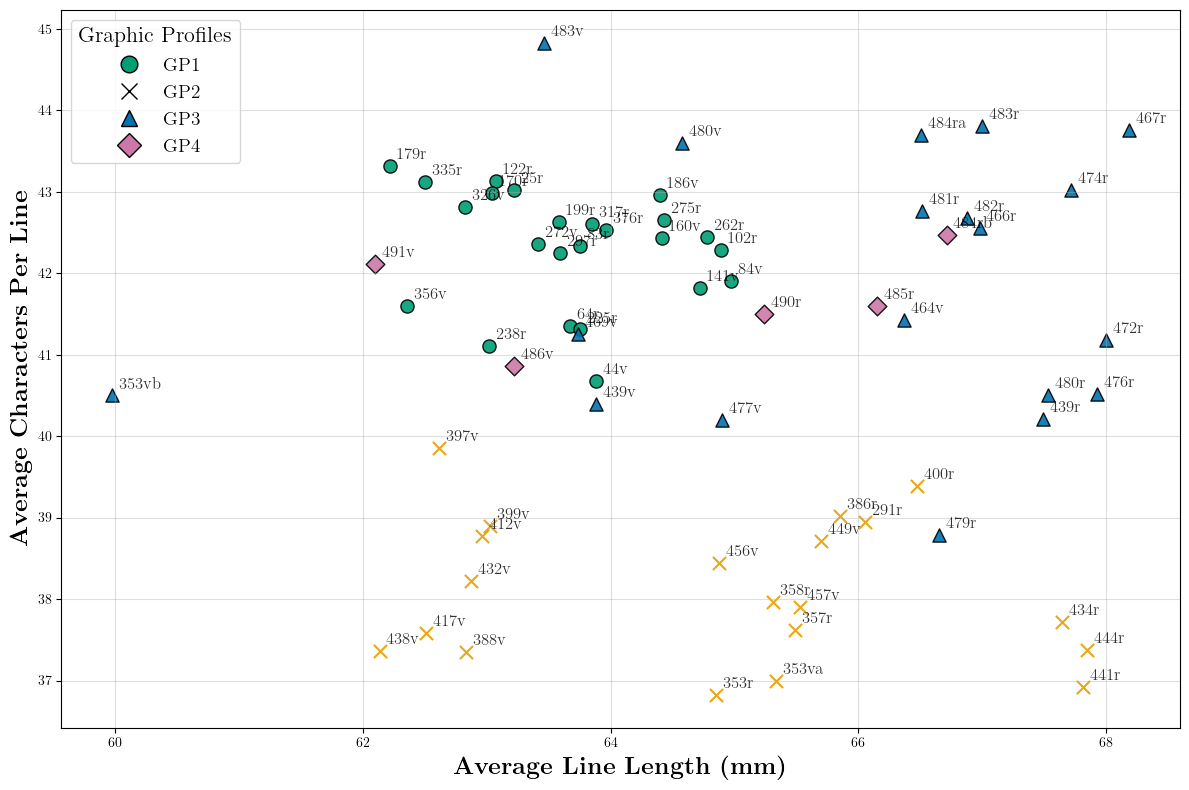

In [12]:
image_dpi = 400

# Step 1: calculate
df_subfolder_stats, df_gp_stats = calculate_line_statistics(
    images_path, full_images_path, annotation_full_lines_path, stats_dir, image_dpi
)

# Step 2: load mappings
folio_mapping, graphic_profile_mapping = create_metadata_mapping(annotation_json_path)

# Step 3: plot
create_scatter_plot(
    df_subfolder_stats,
    graphic_profile_mapping,
    folio_mapping,
    os.path.join(stats_dir, "avg_line_length_characters_per_GP_scatterplot.png")
)